In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns   
import os
# import czifile

import tensorflow as tf
print(tf.__version__)

import n2v
from n2v.models import N2VConfig, N2V
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

2.10.0


In [ ]:
tf.config.list_physical_devices('GPU')

In [ ]:
# Use the GPU more efficiently.
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

In [5]:
#Current shape is: (1, 1, 2, 23, 587, 587, 1) - We need to get it to a ZYXC shape
test_img = test_img[0,0,:,:,:,:,0]
print("Shape of the image after dropping some dims is: ", test_img.shape) #(2, 23, 587, 587)
test_img = np.moveaxis(test_img, 0, 3)
print("Shape of the image after moving axes is: ", test_img.shape) # (23, 587, 587, 2)

NameError: name 'test_img' is not defined

In [6]:
imgs = datagen.load_imgs_from_directory(directory = "Denoising_Dataset/Test/high/", 
                                        filter='*.tif',dims='YX')  #ZYX for 3D
# import cv2

# # File path of the image
# file_path = "Denoising_Dataset/Training/high/cell migration high and low - Position 2_XY1562737769_Z0_T0_.tif"

# # Load the image
# imgs = cv2.imread(file_path)

# imgs = imgs[0]
print("Number of images",len(imgs))
print('shape of loaded images: ',imgs[0].shape)
imgs[0] = imgs[0][...,:3]
print('shape without alpha:    ',imgs[0].shape)
print('The data type of the first image is: ', imgs[0].dtype)


Number of images 5
shape of loaded images:  (1, 1024, 1024, 1)
shape without alpha:     (1, 1024, 1024, 1)
The data type of the first image is:  float32


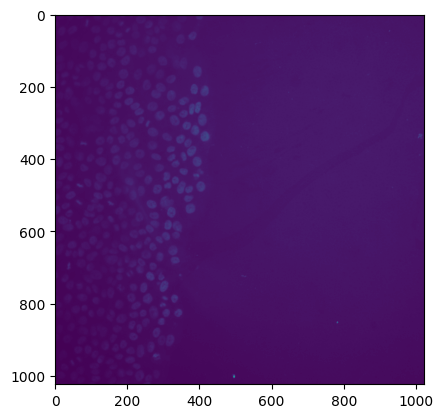

In [7]:
plt.figure()
plt.imshow(imgs[0][0,:,:,:])
plt.show()

In [8]:
patch_size = 64

In [9]:
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)


Generated patches: (2048, 64, 64, 1)
Generated patches: (2048, 64, 64, 1)
Generated patches: (2048, 64, 64, 1)
Generated patches: (2048, 64, 64, 1)
Generated patches: (2048, 64, 64, 1)


In [10]:
patches.shape

(10240, 64, 64, 1)

In [11]:
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [12]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(8192, 64, 64, 1)
float32
(2048, 64, 64, 1)


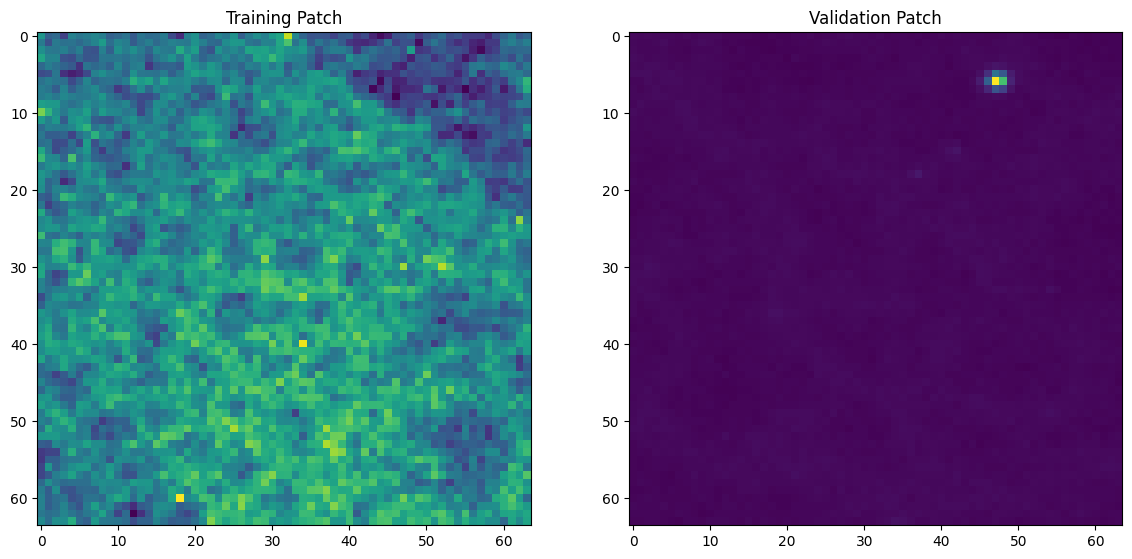

In [13]:

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,...])
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,...])
plt.title('Validation Patch');

<h2>Configure</h2><p>

Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the N2VConfig constructor for a description of all parameters.

<p>
When creating the config-object, we provide the training data X. From X we extract mean and std that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from X.
<p>
Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased train_batch_size and batch_norm. To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter n2v_manipulator with default value 'uniform_withCP'. Most pixel manipulators will compute the replacement value based on a neighborhood. With n2v_neighborhood_radius we can control its size.
<p>
<h3>Other pixel manipulators:</h3>
<p>
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
<br>
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = n2v_neighborhood_radius
<br>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
<br>
* identity: performs no pixel manipulation
<br>
For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via n2v_perc_pix.
<p>
For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size n2v_patch_shape are extracted during training. Default patch shape is set to (64, 64).
<p>
In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the single_net_per_channel option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough.<br>
Note: Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.
<p>
**Warning:** to make this example notebook execute faster, we have set train_epochs to only 10.
For better results we suggest 100 to 200 train_epochs.


In [14]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch 
# is shown once per epoch. 
train_batch = 32
config = N2VConfig(X, unet_kern_size=3, 
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse', 
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['5530.101'],
 'stds': ['2976.815'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 256,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [15]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D_denoiser'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

c:\Users\VJ\anaconda3\envs\dl\lib\site-packages\n2v\models\n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: C:\Users\VJ\Desktop\Microbial Analysis\models\n2v_2D_denoiser
  warnings.warn(


In [16]:
# We are ready to start training now.
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 2048/2048 [00:00<00:00, 3731.69it/s]


Epoch 1/20
256/256 [==============================] - 42s 120ms/step - loss: 0.0858 - n2v_mse: 0.0858 - n2v_abs: 0.1562 - val_loss: 0.1406 - val_n2v_mse: 0.1406 - val_n2v_abs: 0.2740 - lr: 4.0000e-04
Epoch 2/20
256/256 [==============================] - 29s 115ms/step - loss: 0.0473 - n2v_mse: 0.0473 - n2v_abs: 0.1262 - val_loss: 0.0295 - val_n2v_mse: 0.0295 - val_n2v_abs: 0.1349 - lr: 4.0000e-04
Epoch 3/20
256/256 [==============================] - 29s 115ms/step - loss: 0.0351 - n2v_mse: 0.0351 - n2v_abs: 0.1183 - val_loss: 0.0105 - val_n2v_mse: 0.0105 - val_n2v_abs: 0.0702 - lr: 4.0000e-04
Epoch 4/20
256/256 [==============================] - 30s 116ms/step - loss: 0.0279 - n2v_mse: 0.0279 - n2v_abs: 0.1042 - val_loss: 0.0061 - val_n2v_mse: 0.0061 - val_n2v_abs: 0.0575 - lr: 4.0000e-04
Epoch 5/20
256/256 [==============================] - 29s 115ms/step - loss: 0.0266 - n2v_mse: 0.0266 - n2v_abs: 0.1063 - val_loss: 0.0078 - val_n2v_mse: 0.0078 - val_n2v_abs: 0.0677 - lr: 4.0000e-04


['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


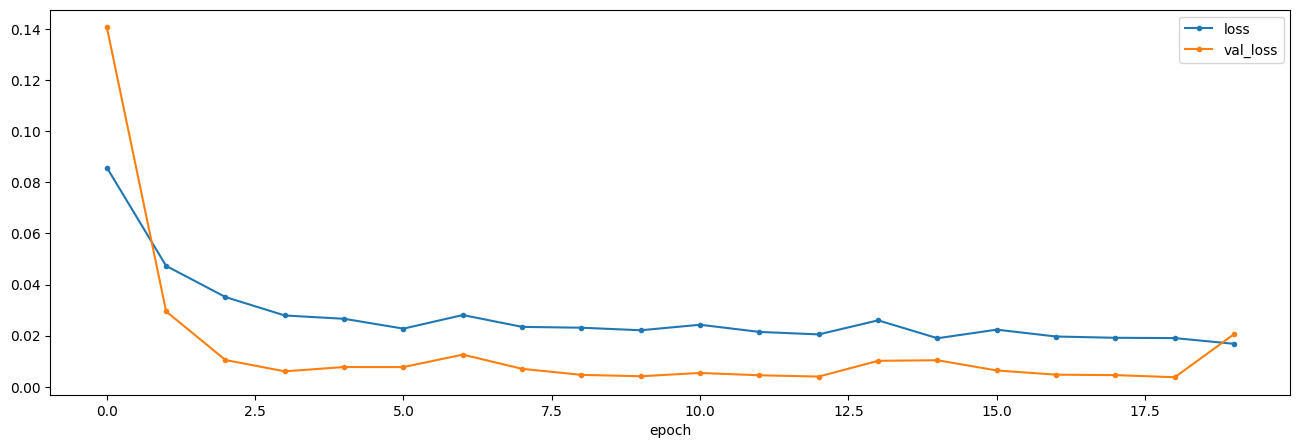

In [17]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

In [18]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [19]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.  
model_name = 'n2v_2D_denoiser'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [23]:
# We load the data we want to process.
img = imread('datasets\Denoising_Dataset\test\High\cell migration high and low - Position 0 - 1_XY1562738052_Z0.tif')
img.dtype

OSError: [Errno 22] Invalid argument: 'datasets\\Denoising_Dataset\test\\High\\cell migration high and low - Position 0 - 1_XY1562738052_Z0.tif'

In [ ]:

# Here we denoise the image (predict)
# The parameter 'n_tiles' can be used if images are to big for the GPU memory.
# If we do not provide the n_tiles' parameter the system will automatically try to find an appropriate tiling.
# This can take longer.
pred = model.predict(img, axes='YXC')



In [ ]:
pred.shape

(510, 738, 3)

In [ ]:
# Let's look at the results.
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Input')
plt.subplot(1,2,2)
plt.imshow(pred)
plt.title('Prediction')

In [ ]:
save_tiff_imagej_compatible('pred_train.tif', pred, axes='YXC')